## Pre-processing

Some custom functions

In [1]:
import pandas as pd
import os
import glob
import numpy as np
from pandas.io.common import EmptyDataError
from scipy.stats import zscore

def get_filesList(procedure):
    '''Function to get a list of filenames from each procedure-based folder'''
    # Set directory
    my_dir = procedure + "/"
    filesList = []
    os.chdir(my_dir)

    # Build up list of files
    for files in glob.glob("*.txt"):
        filesList.append(files) #filename with extension
    
    # Reset by ascending up one level in the directory
    my_dir = "../"
    os.chdir(my_dir)
    
    return filesList

def get_dataframe(filesList):     
    '''Function to read in text files, split MTM and PSM sensors, normalize, and save as a dataframe'''

    # Create blank dataframe
    procedure = pd.DataFrame()
    
    # Enter into sub-level depending on procedure
    if filesList is KT_list:
        os.chdir("knot_tying/")
    elif filesList is NP_list:
        os.chdir("needle_passing/")
    elif filesList is S_list:
        os.chdir("suturing/")
    
    # Iterate through filelist
    for ijk in filesList:
        try:
            # Read each txt to a dataframe
            frame = pd.read_csv(ijk, header=None, delim_whitespace=True)
            frame = frame.apply(zscore) # normalize all columns of df
            frame['name'] = os.path.splitext(ijk)[0] # save file name for each row

            # Split MTM and PSM categories into sensor1 and sensor2
            sensor1 = frame.iloc[:, list(range(38)) + [-1]]
            sensor2 = frame.iloc[:, 38:]
            sensor2.columns = list(range(0, 38)) + ['name'] # sensor2 column names should be consistent with sensor1's

            # Concatenate them into the blank dataframe
            procedure = procedure.append(sensor1)
            procedure = procedure.append(sensor2)

        except EmptyDataError: # Skip the file if there's an error
            continue
    
    # Reset by ascending up one level in the directory
    os.chdir("../")

    return procedure

def merge_labels(labels):
    '''Function to add labels'''
    
    # Set procedure to the input df which corresponds with the input parameter
    if labels is knot_tying_labels:
        procedure = knot_tying
    elif labels is needle_passing_labels:
        procedure = needle_passing
    elif labels is suturing_labels:
        procedure = suturing
    
    # Merge labels with the input df
    procedure = procedure.merge(labels, left_on='name', right_on=0)
    procedure = procedure[procedure.columns[:-7]]
    procedure = procedure.drop(['0_y'],axis =1)
    procedure.columns = list(range(0, 38)) + ['name'] + ['skill']
    
    return procedure

def sliding_window(procedure, step_size=30, window_size=60):
    '''Function to perform single-window cropping'''

    sequences = []
    rows = 0 # rows
    cols = 0 # cols
    
    while (rows + window_size) < len(procedure):
        sequences.append(procedure[rows:(rows + window_size - 1)])
        rows = rows + step_size
        cols = cols + 1
        
    return sequences

def shape_inputs(crops):
    '''Function to extract inputs'''
    
    # Set as 3D array
    procedure_x = np.hstack(crops).reshape(len(crops), 59, 40) 
    
    # Briefly convert to array so we can remove the last two columns
    procedure_x = np.asarray([sublist[:-2] for sample in procedure_x for sublist in sample])
    
    # Reshape as 3D array. Note: There is probably a better way than having to use hstack() twice
    procedure_x = np.hstack(procedure_x).reshape(len(crops), 59, 38) 

    return procedure_x

def encode_labels(y_list):
    '''Function to encode labels'''
    
    labels = []

    for l in y_list:
        if l == 'N':
            labels.append(0)
        elif l == 'I':
            labels.append(1)
        else:
            labels.append(2)
    
    labels = np.array(labels)
    
    return labels
    
def prepareFor_Keras(procedure):
    '''Function to run split by skill level, run sliding window, and prepare 3D arrays from dataframes'''    

    # Split by skill level and Crop
    procedure_N = sliding_window(procedure[procedure['skill'] == 'N'])
    procedure_I = sliding_window(procedure[procedure['skill'] == 'I'])
    procedure_E = sliding_window(procedure[procedure['skill'] == 'E'])
    
    # Get inputs
    procedure_N_x = shape_inputs(procedure_N)
    procedure_I_x = shape_inputs(procedure_I)
    procedure_E_x = shape_inputs(procedure_E)
    
    # Get outputs
    procedure_N_y = np.full(len(procedure_N_x), "N")
    procedure_I_y = np.full(len(procedure_I_x), "I")
    procedure_E_y = np.full(len(procedure_E_x), "E")

    # Concatenate all skill levels into one X df and one Y df
    procedure_x = np.concatenate((procedure_N_x, procedure_I_x, procedure_E_x), axis=0)
    procedure_y = np.concatenate((procedure_N_y, procedure_I_y, procedure_E_y), axis=0)
    
    # One-hot encode the y labels
    procedure_y = encode_labels(procedure_y)
    
    return procedure_x, procedure_y

#### Data Loading

In [2]:
# Load txt files containing sensor data. Put into lists by surgical task
procedures = ["knot_tying", "needle_passing", "suturing"]
KT_list = get_filesList(procedures[0])
NP_list = get_filesList(procedures[1])
S_list = get_filesList(procedures[2])

In [3]:
# Load txt files containing labels (i.e. novice, intermediate, expert)
knot_tying_labels = pd.read_csv("labels/meta_file_Knot_Tying.txt", header=None, delim_whitespace=True)
needle_passing_labels = pd.read_csv("labels/meta_file_Needle_Passing.txt", header=None, delim_whitespace=True)
suturing_labels = pd.read_csv("labels/meta_file_Suturing.txt", header=None, delim_whitespace=True)

#### Data Preparation

In [4]:
# Convert lists into dataframes
knot_tying = get_dataframe(KT_list)
needle_passing = get_dataframe(NP_list)
suturing = get_dataframe(S_list)

In [5]:
# Merge input dfs and labels
knot_tying = merge_labels(knot_tying_labels)
needle_passing = merge_labels(needle_passing_labels)
suturing = merge_labels(suturing_labels)

In [6]:
# Prepare dataframes for Keras
knot_tying_x, knot_tying_y = prepareFor_Keras(knot_tying)
needle_passing_x, needle_passing_y = prepareFor_Keras(needle_passing)
suturing_x, suturing_y = prepareFor_Keras(suturing)

In [7]:
# Check number of crops
print("Number of crops for Knot-Tying: " + str(len(knot_tying_x)))
print("Number of crops for Needle-Passing: " + str(len(needle_passing_x)))
print("Number of crops for Suturing: " + str(len(suturing_x)))

Number of crops for Knot-Tying: 4134
Number of crops for Needle-Passing: 6052
Number of crops for Suturing: 8754


#### Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split

# Run splits
knot_tying_train_data, knot_tying_test_data, knot_tying_train_labels, knot_tying_test_labels =  train_test_split(knot_tying_x, knot_tying_y, test_size=0.2)
needle_passing_train_data, needle_passing_test_data, needle_passing_train_labels, needle_passing_test_labels =  train_test_split(needle_passing_x, needle_passing_y, test_size=0.2)
suturing_train_data, suturing_test_data, suturing_train_labels, suturing_test_labels =  train_test_split(suturing_x, suturing_y, test_size=0.2)

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Convert X's to tensors
knot_tying_train_data = tf.convert_to_tensor(knot_tying_train_data, np.float32)
knot_tying_test_data = tf.convert_to_tensor(knot_tying_test_data, np.float32)
needle_passing_train_data = tf.convert_to_tensor(needle_passing_train_data, np.float32)
needle_passing_test_data = tf.convert_to_tensor(needle_passing_test_data, np.float32)
suturing_train_data = tf.convert_to_tensor(suturing_train_data, np.float32)
suturing_test_data = tf.convert_to_tensor(suturing_test_data, np.float32)

# Convert Y's to categorical variables
knot_tying_train_labels = to_categorical(knot_tying_train_labels)
knot_tying_test_labels = to_categorical(knot_tying_test_labels)
needle_passing_train_labels = to_categorical(needle_passing_train_labels)
needle_passing_test_labels = to_categorical(needle_passing_test_labels)
suturing_train_labels = to_categorical(suturing_train_labels)
suturing_test_labels = to_categorical(suturing_test_labels)

## Modeling

### SimpleRNN

##### Knot_tying

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.SimpleRNN(units = 8, # dimension of output space
                           input_shape=(knot_tying_train_data.shape[1], knot_tying_train_data.shape[2])))
model.add(layers.Dense(3, activation='sigmoid'))

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(knot_tying_train_data, knot_tying_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(knot_tying_test_data, knot_tying_test_labels)
                   )

Train on 3307 samples, validate on 827 samples
Epoch 1/50
3307/3307 [==============================] - 4s 1ms/sample - loss: 1.1109 - accuracy: 0.3750 - val_loss: 1.0851 - val_accuracy: 0.4063
Epoch 2/50
3307/3307 [==============================] - 1s 451us/sample - loss: 1.0657 - accuracy: 0.4264 - val_loss: 1.0506 - val_accuracy: 0.4583
Epoch 3/50
3307/3307 [==============================] - 2s 463us/sample - loss: 1.0336 - accuracy: 0.4865 - val_loss: 1.0278 - val_accuracy: 0.4958
Epoch 4/50
3307/3307 [==============================] - 1s 423us/sample - loss: 1.0096 - accuracy: 0.5162 - val_loss: 1.0101 - val_accuracy: 0.5163
Epoch 5/50
3307/3307 [==============================] - 1s 413us/sample - loss: 0.9909 - accuracy: 0.5268 - val_loss: 0.9970 - val_accuracy: 0.5236
Epoch 6/50
3307/3307 [==============================] - 1s 402us/sample - loss: 0.9752 - accuracy: 0.5437 - val_loss: 0.9849 - val_accuracy: 0.5345
Epoch 7/50
3307/3307 [==============================] - 1s 404us/sa

<Figure size 432x288 with 0 Axes>

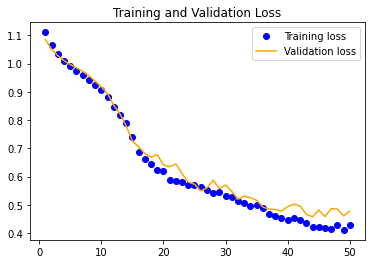

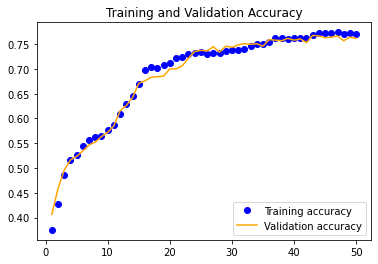

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

# Accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

##### Needle_Passing

In [15]:
model2 = models.Sequential()
model2.add(layers.SimpleRNN(units = 8, # dimension of output space
                           input_shape=(needle_passing_train_data.shape[1], needle_passing_train_data.shape[2])))
model2.add(layers.Dense(3, activation='sigmoid'))

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 8)                 376       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [17]:
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history2 = model2.fit(needle_passing_train_data, needle_passing_train_labels,
                    epochs=50,
                    batch_size=32, # comparable with 16
                    validation_data=(needle_passing_test_data, needle_passing_test_labels)
                   )

Train on 4841 samples, validate on 1211 samples
Epoch 1/50
4841/4841 [==============================] - 4s 847us/sample - loss: 1.1318 - accuracy: 0.3247 - val_loss: 1.1078 - val_accuracy: 0.3443
Epoch 2/50
4841/4841 [==============================] - 2s 447us/sample - loss: 1.0965 - accuracy: 0.3611 - val_loss: 1.0879 - val_accuracy: 0.3906
Epoch 3/50
4841/4841 [==============================] - 2s 428us/sample - loss: 1.0790 - accuracy: 0.3815 - val_loss: 1.0750 - val_accuracy: 0.4046
Epoch 4/50
4841/4841 [==============================] - 2s 419us/sample - loss: 1.0666 - accuracy: 0.4001 - val_loss: 1.0654 - val_accuracy: 0.4154
Epoch 5/50
4841/4841 [==============================] - 2s 431us/sample - loss: 1.0561 - accuracy: 0.4214 - val_loss: 1.0555 - val_accuracy: 0.4261
Epoch 6/50
4841/4841 [==============================] - 2s 389us/sample - loss: 1.0443 - accuracy: 0.4390 - val_loss: 1.0444 - val_accuracy: 0.4426
Epoch 7/50
4841/4841 [==============================] - 2s 394us

<Figure size 432x288 with 0 Axes>

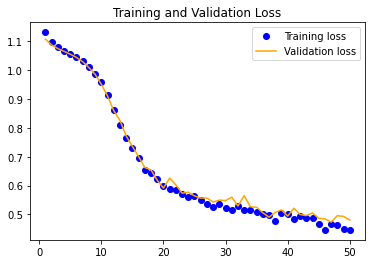

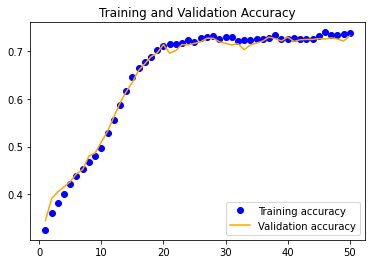

<Figure size 432x288 with 0 Axes>

In [19]:
# Accuracy and loss
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(acc2) + 1)

# Plot Loss
plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs2, acc2, 'bo', label='Training accuracy')
plt.plot(epochs2, val_acc2, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

##### Suturing

In [20]:
model3 = models.Sequential()
model3.add(layers.SimpleRNN(units = 8, # dimension of output space
                           input_shape=(suturing_train_data.shape[1], suturing_train_data.shape[2])))
model3.add(layers.Dense(3, activation='sigmoid'))

In [21]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 8)                 376       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [22]:
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history3 = model3.fit(suturing_train_data, suturing_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(suturing_test_data, suturing_test_labels)
                   )

Train on 7003 samples, validate on 1751 samples
Epoch 1/50
7003/7003 [==============================] - 4s 596us/sample - loss: 1.1002 - accuracy: 0.3940 - val_loss: 1.0539 - val_accuracy: 0.4717
Epoch 2/50
7003/7003 [==============================] - 3s 385us/sample - loss: 1.0052 - accuracy: 0.5433 - val_loss: 0.9818 - val_accuracy: 0.5802
Epoch 3/50
7003/7003 [==============================] - 3s 391us/sample - loss: 0.9478 - accuracy: 0.5899 - val_loss: 0.9376 - val_accuracy: 0.6014
Epoch 4/50
7003/7003 [==============================] - 3s 383us/sample - loss: 0.9046 - accuracy: 0.6057 - val_loss: 0.8944 - val_accuracy: 0.6179
Epoch 5/50
7003/7003 [==============================] - 3s 402us/sample - loss: 0.8518 - accuracy: 0.6324 - val_loss: 0.8336 - val_accuracy: 0.6453
Epoch 6/50
7003/7003 [==============================] - 3s 394us/sample - loss: 0.7931 - accuracy: 0.6593 - val_loss: 0.7777 - val_accuracy: 0.6693
Epoch 7/50
7003/7003 [==============================] - 3s 380us

<Figure size 432x288 with 0 Axes>

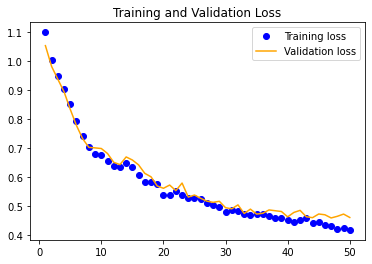

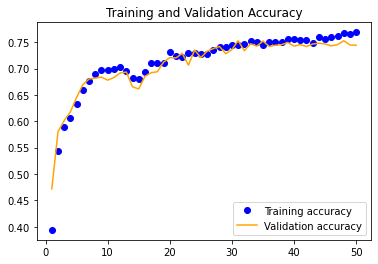

<Figure size 432x288 with 0 Axes>

In [24]:
# Accuracy and loss
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs3 = range(1, len(acc3) + 1)

# Plot Loss
plt.plot(epochs3, loss3, 'bo', label='Training loss')
plt.plot(epochs3, val_loss3, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs3, acc3, 'bo', label='Training accuracy')
plt.plot(epochs3, val_acc3, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

### DeepRNN

##### Knot_tying

In [25]:
model_deep = models.Sequential()
model_deep.add(layers.SimpleRNN(units = 8, # dimension of output space
                           input_shape=(knot_tying_train_data.shape[1], knot_tying_train_data.shape[2]),
                               return_sequences=True))
model_deep.add(layers.SimpleRNN(units = 8)) # dimension of output space
model_deep.add(layers.Dense(3, activation='sigmoid'))

In [26]:
model_deep.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history_deep = model_deep.fit(knot_tying_train_data, knot_tying_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(knot_tying_test_data, knot_tying_test_labels)
                   )

Train on 3307 samples, validate on 827 samples
Epoch 1/50
3307/3307 [==============================] - 5s 1ms/sample - loss: 1.1116 - accuracy: 0.3559 - val_loss: 1.0852 - val_accuracy: 0.3688
Epoch 2/50
3307/3307 [==============================] - 2s 691us/sample - loss: 1.0637 - accuracy: 0.4370 - val_loss: 1.0553 - val_accuracy: 0.4607
Epoch 3/50
3307/3307 [==============================] - 2s 702us/sample - loss: 1.0304 - accuracy: 0.5044 - val_loss: 1.0291 - val_accuracy: 0.5054
Epoch 4/50
3307/3307 [==============================] - 2s 719us/sample - loss: 1.0013 - accuracy: 0.5325 - val_loss: 1.0059 - val_accuracy: 0.5236
Epoch 5/50
3307/3307 [==============================] - 2s 686us/sample - loss: 0.9711 - accuracy: 0.5488 - val_loss: 0.9675 - val_accuracy: 0.5369
Epoch 6/50
3307/3307 [==============================] - 2s 655us/sample - loss: 0.9166 - accuracy: 0.5694 - val_loss: 0.9351 - val_accuracy: 0.5671
Epoch 7/50
3307/3307 [==============================] - 2s 656us/sa

<Figure size 432x288 with 0 Axes>

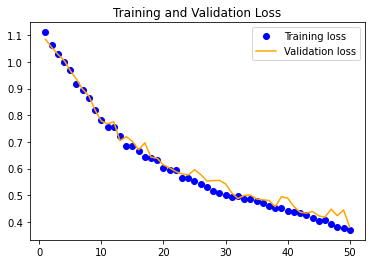

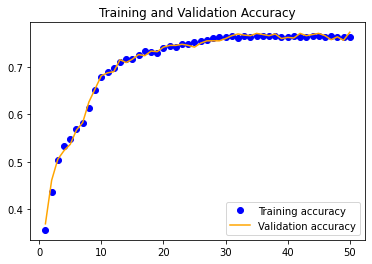

<Figure size 432x288 with 0 Axes>

In [28]:
# Accuracy and loss
acc_deep = history_deep.history['accuracy']
val_acc_deep = history_deep.history['val_accuracy']
loss_deep = history_deep.history['loss']
val_loss_deep = history_deep.history['val_loss']

epochs_deep = range(1, len(acc_deep) + 1)

# Plot Loss
plt.plot(epochs_deep, loss_deep, 'bo', label='Training loss')
plt.plot(epochs_deep, val_loss_deep, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs_deep, acc_deep, 'bo', label='Training accuracy')
plt.plot(epochs_deep, val_acc_deep, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

##### Needle_Passing

In [29]:
model_deep2 = models.Sequential()
model_deep2.add(layers.SimpleRNN(units = 8, # dimension of output space
                           input_shape=(needle_passing_train_data.shape[1], needle_passing_train_data.shape[2]),
                               return_sequences=True))
model_deep2.add(layers.SimpleRNN(units = 8))
model_deep2.add(layers.Dense(3, activation='sigmoid'))

In [30]:
model_deep2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 59, 8)             376       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 539
Trainable params: 539
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_deep2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history_deep2 = model_deep2.fit(needle_passing_train_data, needle_passing_train_labels,
                    epochs=50,
                    batch_size=32, # comparable with 16
                    validation_data=(needle_passing_test_data, needle_passing_test_labels)
                   )

Train on 4841 samples, validate on 1211 samples
Epoch 1/50
4841/4841 [==============================] - 6s 1ms/sample - loss: 1.0996 - accuracy: 0.3927 - val_loss: 1.0845 - val_accuracy: 0.4055
Epoch 2/50
4841/4841 [==============================] - 4s 753us/sample - loss: 1.0624 - accuracy: 0.4416 - val_loss: 1.0552 - val_accuracy: 0.4500
Epoch 3/50
4841/4841 [==============================] - 4s 731us/sample - loss: 1.0291 - accuracy: 0.4904 - val_loss: 1.0167 - val_accuracy: 0.4847
Epoch 4/50
4841/4841 [==============================] - 3s 710us/sample - loss: 0.9685 - accuracy: 0.5319 - val_loss: 0.9484 - val_accuracy: 0.5376
Epoch 5/50
4841/4841 [==============================] - 4s 731us/sample - loss: 0.9001 - accuracy: 0.5677 - val_loss: 0.8924 - val_accuracy: 0.5747
Epoch 6/50
4841/4841 [==============================] - 4s 726us/sample - loss: 0.8526 - accuracy: 0.5986 - val_loss: 0.8446 - val_accuracy: 0.6061
Epoch 7/50
4841/4841 [==============================] - 4s 758us/s

<Figure size 432x288 with 0 Axes>

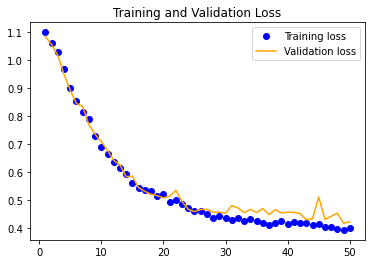

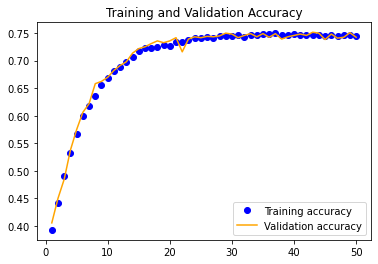

<Figure size 432x288 with 0 Axes>

In [34]:
# Accuracy and loss
acc_deep2 = history_deep2.history['accuracy']
val_acc_deep_2 = history_deep2.history['val_accuracy']
loss_deep2 = history_deep2.history['loss']
val_loss_deep2 = history_deep2.history['val_loss']

epochs_deep2 = range(1, len(acc_deep2) + 1)

# Plot Loss
plt.plot(epochs_deep2, loss_deep2, 'bo', label='Training loss')
plt.plot(epochs_deep2, val_loss_deep2, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs_deep2, acc_deep2, 'bo', label='Training accuracy')
plt.plot(epochs_deep2, val_acc_deep_2, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

##### Suturing

In [35]:
model_deep3 = models.Sequential()
model_deep3.add(layers.SimpleRNN(units = 8, # dimension of output space
                           input_shape=(suturing_train_data.shape[1], suturing_train_data.shape[2]),
                                return_sequences=True))
model_deep3.add(layers.SimpleRNN(units = 8))
model_deep3.add(layers.Dense(3, activation='sigmoid'))

In [36]:
model_deep3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 59, 8)             376       
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 539
Trainable params: 539
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_deep3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
history_deep3 = model_deep3.fit(suturing_train_data, suturing_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(suturing_test_data, suturing_test_labels)
                   )

Train on 7003 samples, validate on 1751 samples
Epoch 1/50
7003/7003 [==============================] - 8s 1ms/sample - loss: 1.0401 - accuracy: 0.4874 - val_loss: 0.9507 - val_accuracy: 0.5894
Epoch 2/50
7003/7003 [==============================] - 6s 801us/sample - loss: 0.9116 - accuracy: 0.5975 - val_loss: 0.8508 - val_accuracy: 0.6156
Epoch 3/50
7003/7003 [==============================] - 5s 783us/sample - loss: 0.8053 - accuracy: 0.6410 - val_loss: 0.7513 - val_accuracy: 0.6688
Epoch 4/50
7003/7003 [==============================] - 5s 754us/sample - loss: 0.7388 - accuracy: 0.6734 - val_loss: 0.6834 - val_accuracy: 0.7122
Epoch 5/50
7003/7003 [==============================] - 5s 756us/sample - loss: 0.6737 - accuracy: 0.7001 - val_loss: 0.6532 - val_accuracy: 0.7144
Epoch 6/50
7003/7003 [==============================] - 5s 757us/sample - loss: 0.6265 - accuracy: 0.7193 - val_loss: 0.5973 - val_accuracy: 0.7339
Epoch 7/50
7003/7003 [==============================] - 5s 723us/s

<Figure size 432x288 with 0 Axes>

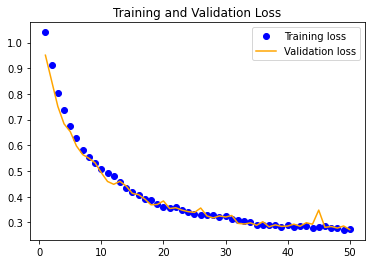

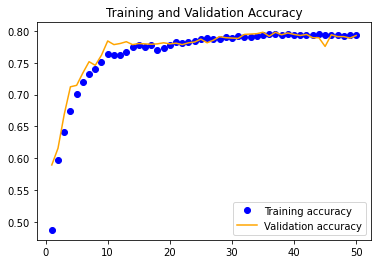

<Figure size 432x288 with 0 Axes>

In [39]:
# Accuracy and loss
acc_deep3 = history_deep3.history['accuracy']
val_acc_deep3 = history_deep3.history['val_accuracy']
loss_deep3 = history_deep3.history['loss']
val_loss_deep3 = history_deep3.history['val_loss']

epochs_deep3 = range(1, len(acc_deep3) + 1)

# Plot Loss
plt.plot(epochs_deep3, loss_deep3, 'bo', label='Training loss')
plt.plot(epochs_deep3, val_loss_deep3, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs_deep3, acc_deep3, 'bo', label='Training accuracy')
plt.plot(epochs_deep3, val_acc_deep3, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

### LSTM

##### Knot_Tying

In [40]:
model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(8,
                          input_shape=(knot_tying_train_data.shape[1], knot_tying_train_data.shape[2]),))
model_lstm.add(layers.Dense(3, activation='sigmoid'))

In [41]:
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 1504      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history_lstm = model_lstm.fit(knot_tying_train_data, knot_tying_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(knot_tying_test_data, knot_tying_test_labels)
                   )

Train on 3307 samples, validate on 827 samples
Epoch 1/50
3307/3307 [==============================] - 5s 1ms/sample - loss: 1.0705 - accuracy: 0.4206 - val_loss: 1.0334 - val_accuracy: 0.5224
Epoch 2/50
3307/3307 [==============================] - 2s 550us/sample - loss: 0.9841 - accuracy: 0.5791 - val_loss: 0.9428 - val_accuracy: 0.5925
Epoch 3/50
3307/3307 [==============================] - 2s 571us/sample - loss: 0.8528 - accuracy: 0.6523 - val_loss: 0.7653 - val_accuracy: 0.6747
Epoch 4/50
3307/3307 [==============================] - 2s 559us/sample - loss: 0.6819 - accuracy: 0.7418 - val_loss: 0.6277 - val_accuracy: 0.7678
Epoch 5/50
3307/3307 [==============================] - 2s 553us/sample - loss: 0.5962 - accuracy: 0.7666 - val_loss: 0.5653 - val_accuracy: 0.7727
Epoch 6/50
3307/3307 [==============================] - 2s 549us/sample - loss: 0.5341 - accuracy: 0.7681 - val_loss: 0.5145 - val_accuracy: 0.7690
Epoch 7/50
3307/3307 [==============================] - 2s 551us/sa

<Figure size 432x288 with 0 Axes>

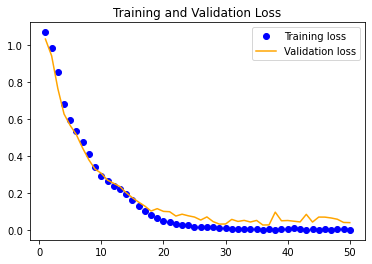

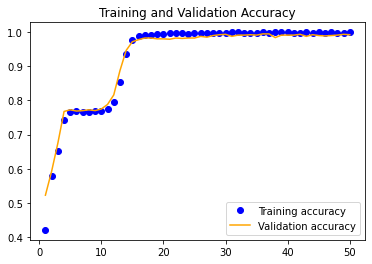

<Figure size 432x288 with 0 Axes>

In [44]:
# Accuracy and loss
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

##### Needle_Passing

In [45]:
model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(8,
                          input_shape=(needle_passing_train_data.shape[1], needle_passing_train_data.shape[2]),))
model_lstm2.add(layers.Dense(3, activation='sigmoid'))

In [46]:
model_lstm2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 1504      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 27        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_lstm2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history_lstm2 = model_lstm2.fit(needle_passing_train_data, needle_passing_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(needle_passing_test_data, needle_passing_test_labels)
                   )

Train on 4841 samples, validate on 1211 samples
Epoch 1/50
4841/4841 [==============================] - 6s 1ms/sample - loss: 1.0752 - accuracy: 0.4220 - val_loss: 1.0266 - val_accuracy: 0.5087
Epoch 2/50
4841/4841 [==============================] - 3s 596us/sample - loss: 0.9628 - accuracy: 0.6063 - val_loss: 0.8670 - val_accuracy: 0.6994
Epoch 3/50
4841/4841 [==============================] - 3s 617us/sample - loss: 0.7546 - accuracy: 0.7424 - val_loss: 0.6745 - val_accuracy: 0.7605
Epoch 4/50
4841/4841 [==============================] - 3s 639us/sample - loss: 0.6318 - accuracy: 0.7668 - val_loss: 0.5720 - val_accuracy: 0.7828
Epoch 5/50
4841/4841 [==============================] - 3s 568us/sample - loss: 0.5249 - accuracy: 0.7943 - val_loss: 0.4815 - val_accuracy: 0.8109
Epoch 6/50
4841/4841 [==============================] - 3s 561us/sample - loss: 0.4373 - accuracy: 0.8265 - val_loss: 0.3966 - val_accuracy: 0.8580
Epoch 7/50
4841/4841 [==============================] - 3s 555us/s

<Figure size 432x288 with 0 Axes>

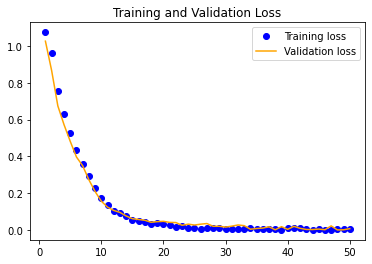

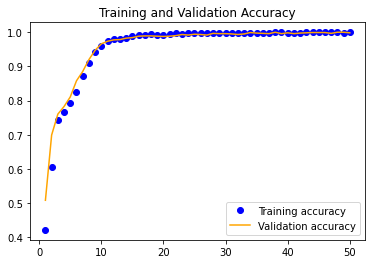

<Figure size 432x288 with 0 Axes>

In [49]:
# Accuracy and loss
acc = history_lstm2.history['accuracy']
val_acc = history_lstm2.history['val_accuracy']
loss = history_lstm2.history['loss']
val_loss = history_lstm2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

##### Needle_Passing

In [50]:
model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(8,
                          input_shape=(needle_passing_train_data.shape[1], needle_passing_train_data.shape[2]),))
model_lstm2.add(layers.Dense(3, activation='sigmoid'))

In [51]:
model_lstm2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 1504      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 27        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_lstm2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
history_lstm2 = model_lstm2.fit(needle_passing_train_data, needle_passing_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(needle_passing_test_data, needle_passing_test_labels)
                   )

Train on 4841 samples, validate on 1211 samples
Epoch 1/50
4841/4841 [==============================] - 6s 1ms/sample - loss: 1.0777 - accuracy: 0.3853 - val_loss: 1.0346 - val_accuracy: 0.4674
Epoch 2/50
4841/4841 [==============================] - 3s 555us/sample - loss: 0.9777 - accuracy: 0.5526 - val_loss: 0.8927 - val_accuracy: 0.6317
Epoch 3/50
4841/4841 [==============================] - 3s 557us/sample - loss: 0.7787 - accuracy: 0.6831 - val_loss: 0.6723 - val_accuracy: 0.6912
Epoch 4/50
4841/4841 [==============================] - 3s 587us/sample - loss: 0.6094 - accuracy: 0.7255 - val_loss: 0.5854 - val_accuracy: 0.7135
Epoch 5/50
4841/4841 [==============================] - 3s 581us/sample - loss: 0.5302 - accuracy: 0.7434 - val_loss: 0.5213 - val_accuracy: 0.7407
Epoch 6/50
4841/4841 [==============================] - 3s 561us/sample - loss: 0.4692 - accuracy: 0.7550 - val_loss: 0.4644 - val_accuracy: 0.7498
Epoch 7/50
4841/4841 [==============================] - 3s 567us/s

<Figure size 432x288 with 0 Axes>

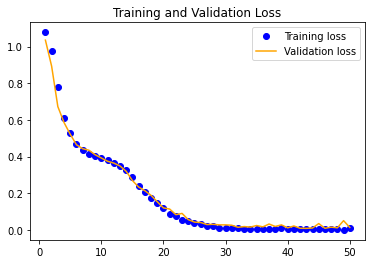

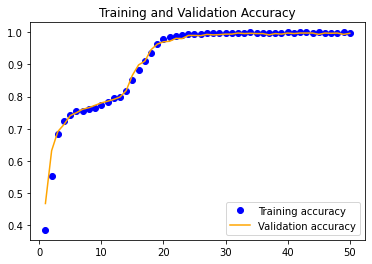

<Figure size 432x288 with 0 Axes>

In [54]:
# Accuracy and loss
acc = history_lstm2.history['accuracy']
val_acc = history_lstm2.history['val_accuracy']
loss = history_lstm2.history['loss']
val_loss = history_lstm2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

##### Suturing

In [55]:
model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(8,
                          input_shape=(suturing_train_data.shape[1], suturing_train_data.shape[2]),))
model_lstm3.add(layers.Dense(3, activation='sigmoid'))

In [56]:
model_lstm3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 1504      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 27        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


In [57]:
model_lstm3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
history_lstm3 = model_lstm3.fit(suturing_train_data, suturing_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(suturing_test_data, suturing_test_labels)
                   )

Train on 7003 samples, validate on 1751 samples
Epoch 1/50
7003/7003 [==============================] - 7s 1ms/sample - loss: 1.0149 - accuracy: 0.5379 - val_loss: 0.9363 - val_accuracy: 0.6168
Epoch 2/50
7003/7003 [==============================] - 4s 553us/sample - loss: 0.7990 - accuracy: 0.6821 - val_loss: 0.6476 - val_accuracy: 0.7556
Epoch 3/50
7003/7003 [==============================] - 4s 554us/sample - loss: 0.5464 - accuracy: 0.7919 - val_loss: 0.4586 - val_accuracy: 0.8132
Epoch 4/50
7003/7003 [==============================] - 4s 580us/sample - loss: 0.3658 - accuracy: 0.8816 - val_loss: 0.2938 - val_accuracy: 0.9189
Epoch 5/50
7003/7003 [==============================] - 4s 558us/sample - loss: 0.2281 - accuracy: 0.9503 - val_loss: 0.1965 - val_accuracy: 0.9646
Epoch 6/50
7003/7003 [==============================] - 4s 542us/sample - loss: 0.1571 - accuracy: 0.9730 - val_loss: 0.1445 - val_accuracy: 0.9743
Epoch 7/50
7003/7003 [==============================] - 4s 588us/s

<Figure size 432x288 with 0 Axes>

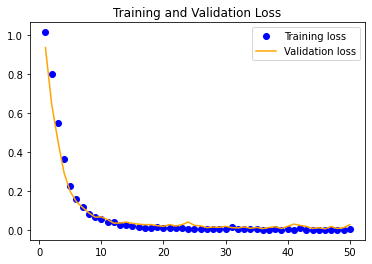

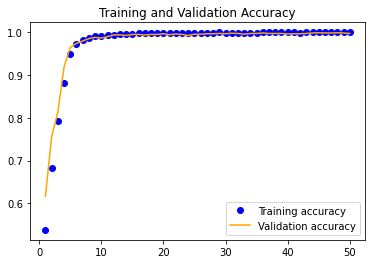

<Figure size 432x288 with 0 Axes>

In [59]:
# Accuracy and loss
acc = history_lstm3.history['accuracy']
val_acc = history_lstm3.history['val_accuracy']
loss = history_lstm3.history['loss']
val_loss = history_lstm3.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# Plot Accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()